<a href="https://colab.research.google.com/github/NikethnaSri-AI/Aanseaa_Technologies_Internship/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/My Drive/brain_tumor_classification/Training'
test_dir = '/content/drive/My Drive/brain_tumor_classification/Testing'
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
image_paths_train = []
labels_train = []

In [ ]:
for category in categories:
    category_dir = os.path.join(train_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths_train.append(os.path.join(category_dir, filename))
            labels_train.append(category)

In [ ]:
data = pd.DataFrame({
    'image_path': image_paths_train,
    'label': labels_train
})

print(data.head())

                                          image_path         label
0  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
1  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
2  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
3  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
4  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor


In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'])

In [ ]:
image_paths_test = []
labels_test = []

for category in categories:
    category_dir = os.path.join(test_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths_test.append(os.path.join(category_dir, filename))
            labels_test.append(category)
data_test = pd.DataFrame({
    'image_path': image_paths_test,
    'label': labels_test
})

print(data_test.head())

print(len(labels_test))
print(len(labels_train))

                                          image_path         label
0  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
1  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
2  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
3  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
4  /content/drive/My Drive/brain_tumor_classifica...  glioma_tumor
394
2870


In [ ]:
print(f"Training images: {len(train_data)}")
print(f"Validation images: {len(val_data)}")
print(f"Test images: {len(data_test)}")

Training images: 2296
Validation images: 574
Test images: 394


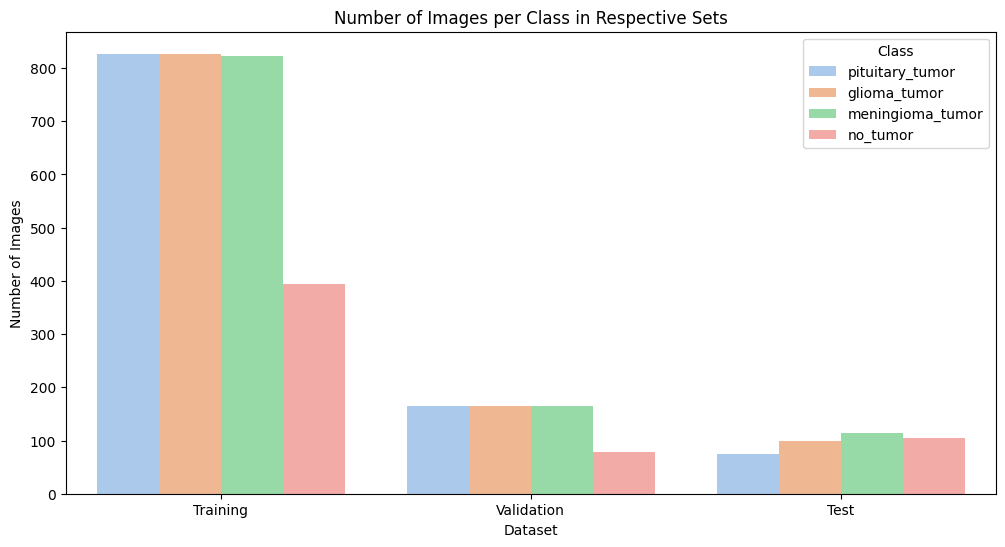

In [ ]:
def count_images_per_class(dataframe):
    return dataframe['label'].value_counts()

train_counts = count_images_per_class(data)
val_counts = count_images_per_class(val_data)
test_counts = count_images_per_class(data_test)

df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
df_train['Dataset'] = 'Training'
df_val = pd.DataFrame(list(val_counts.items()), columns=['Class', 'Count'])
df_val['Dataset'] = 'Validation'
df_test = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])
df_test['Dataset'] = 'Test'
df_all = pd.concat([df_train, df_val, df_test])
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x='Dataset', y='Count', hue='Class', palette='pastel')
plt.title('Number of Images per Class in Respective Sets')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.legend(title='Class')
plt.show()



In [ ]:
image_size = (150, 150)
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.8, 1.2],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')


Found 2296 validated image filenames belonging to 4 classes.


In [ ]:
val_datagen = ImageDataGenerator(
    rescale=1./255)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')


Found 574 validated image filenames belonging to 4 classes.


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255)


test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 394 validated image filenames belonging to 4 classes.


In [ ]:
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())

print(class_indices_train)

print(class_indices_train_list)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
image_shape = (150, 150, 3)
epochs = 10
batch_size=32
steps = train_generator.samples // batch_size
val_steps = test_generator.samples // batch_size
print(steps)
print(val_steps)

71
12


In [ ]:
num_train_classes = len(os.listdir(train_dir))
num_test_classes = len(os.listdir(test_dir))
print("Number of classes in training directory:", num_train_classes)
print("Number of classes in testing directory:", num_test_classes)
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
N_TYPES = len(categories)

Number of classes in training directory: 4
Number of classes in testing directory: 4


In [ ]:
model = models.Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=image_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation="relu"),
    Dropout(0.5),

    Dense(256, activation="relu"),
    Dropout(0.5),

    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint = ModelCheckpoint('best_basic_cnn_model.keras', save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_44 (Ba  (None, 148, 148, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_45 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                     

Evaluation using test data

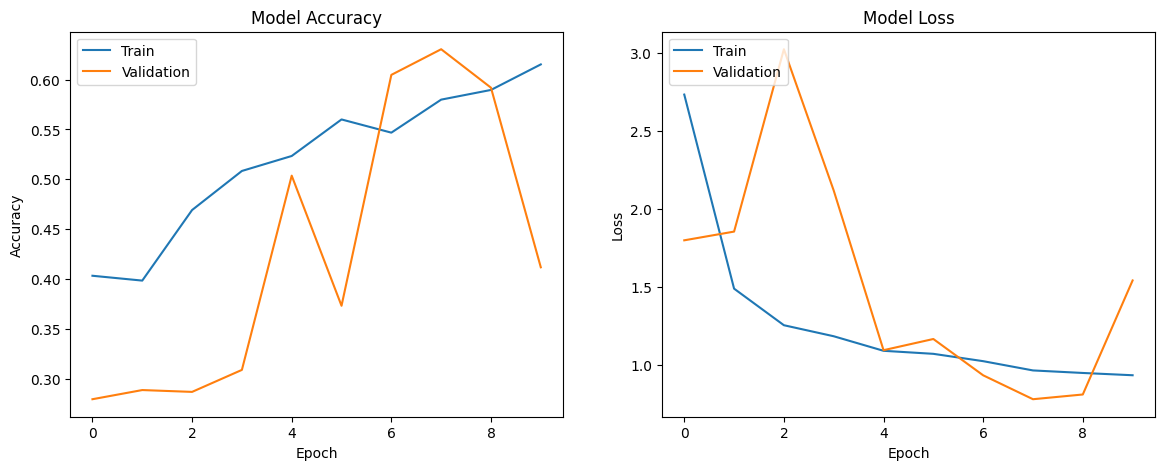

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

12/12 [==============================] - 9s 775ms/step - loss: 2.3939 - accuracy: 0.3724
Test Loss: 2.39392
Test Accuracy: 0.37240


13/13 [==============================] - 9s 657ms/step


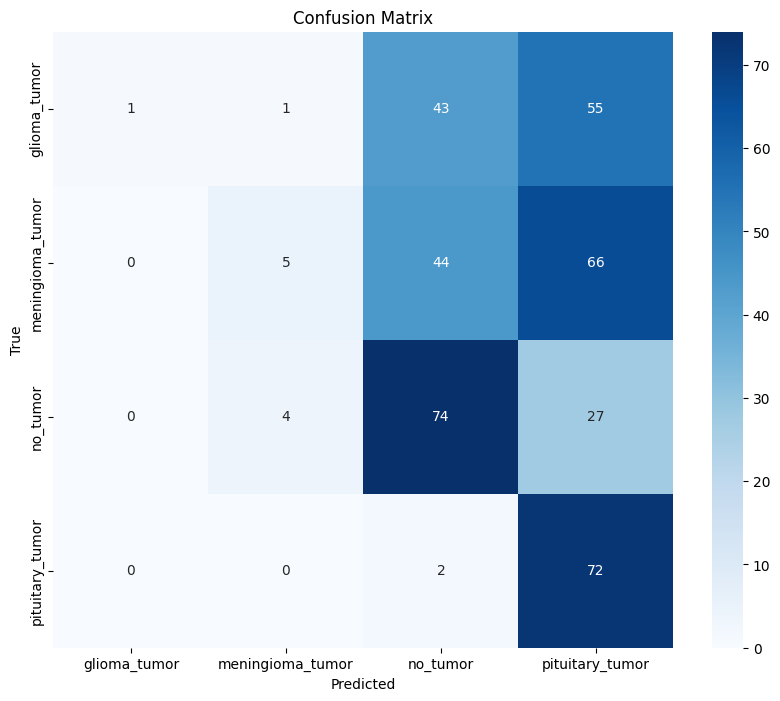

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.01      0.02       100
meningioma_tumor       0.50      0.04      0.08       115
        no_tumor       0.45      0.70      0.55       105
 pituitary_tumor       0.33      0.97      0.49        74

        accuracy                           0.39       394
       macro avg       0.57      0.43      0.29       394
    weighted avg       0.58      0.39      0.27       394



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
test_generator.reset()

predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

In [ ]:
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display



FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Predict', style=ButtonStyle())

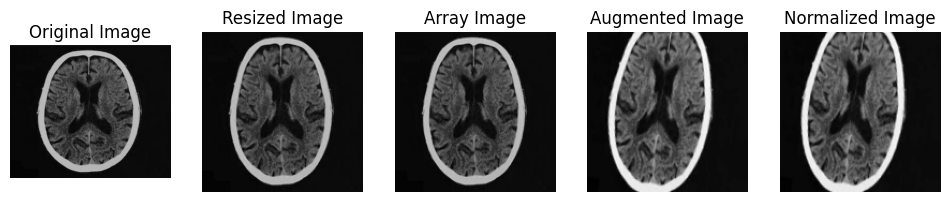

1/1 [==============================] - 0s 35ms/step
The Model predicts that it is a Pituitary Tumor


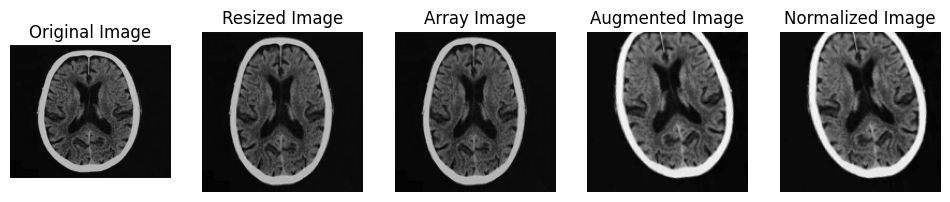

1/1 [==============================] - 0s 35ms/step
The Model predicts that it is a Pituitary Tumor


In [ ]:
def img_pred(upload):
    for name, file_info in upload.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 5, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        img = img.resize((150, 150))
        plt.subplot(1, 5, 2)
        plt.imshow(img)
        plt.title('Resized Image')
        plt.axis('off')
        img_array = img_to_array(img)
        plt.subplot(1, 5, 3)
        plt.imshow(img_array.astype('uint8'))
        plt.title('Array Image')
        plt.axis('off')
        img_array = np.expand_dims(img_array, axis=0)

        augmented_img = train_datagen.random_transform(img_array[0])

        final_image = array_to_img(augmented_img)
        plt.subplot(1, 5, 4)
        plt.imshow(final_image)
        plt.title('Augmented Image')
        plt.axis('off')

        augmented_img = augmented_img / 255.0
        plt.subplot(1, 5, 5)
        plt.imshow(array_to_img(augmented_img))
        plt.title('Normalized Image')
        plt.axis('off')

        plt.show()

        p = model.predict(np.expand_dims(augmented_img, axis=0))
        p = np.argmax(p, axis=1)[0]

        if p == 0:
            prediction = 'Glioma Tumor'
        elif p == 1:
            prediction = 'No Tumor'
        elif p == 2:
            prediction = 'Meningioma Tumor'
        else:
            prediction = 'Pituitary Tumor'

        print(f'The Model predicts that it is a {prediction}')

uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

predict_button = widgets.Button(description="Predict")
display(predict_button)

def on_predict_button_clicked(b):
    if uploader.value:
        img_pred(uploader)
    else:
        print("Please upload an image first.")

predict_button.on_click(on_predict_button_clicked)
